In [136]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [137]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# 输入：语音波形（np 数组） 输出：频谱图
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# 对原始数据集进行读取和拆分

In [138]:
# 将数据集文件夹名字转化为对象
DATASET_PATH = 'speech_commands_v0.01.tar'
data_dir = pathlib.Path(DATASET_PATH)

# 将数据集文件夹对象再次转化为字符串，获取子目录，并转化为np.array,筛选文件夹名字
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != 'validation_list.txt') & (commands != 'testing_list.txt') & (commands != 'LICENSE')]
print('Commands:', commands)


Commands: ['bed' 'bird' 'cat' 'dog']


In [139]:
# 一个专门对音频数据集进行处理划分的API，输入一个文件夹对象，达到裁剪划分数据集的作用
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 6923 files belonging to 4 classes.
Using 5539 files for training.
Using 1384 files for validation.

label names: ['bed' 'bird' 'cat' 'dog']


In [140]:
# 减小一个batch 的维度
train_ds.element_spec
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [141]:
# 进一步拆分出测试和验证集
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

# 尝试打印训练集的音频和标签形状（第一个批次）
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


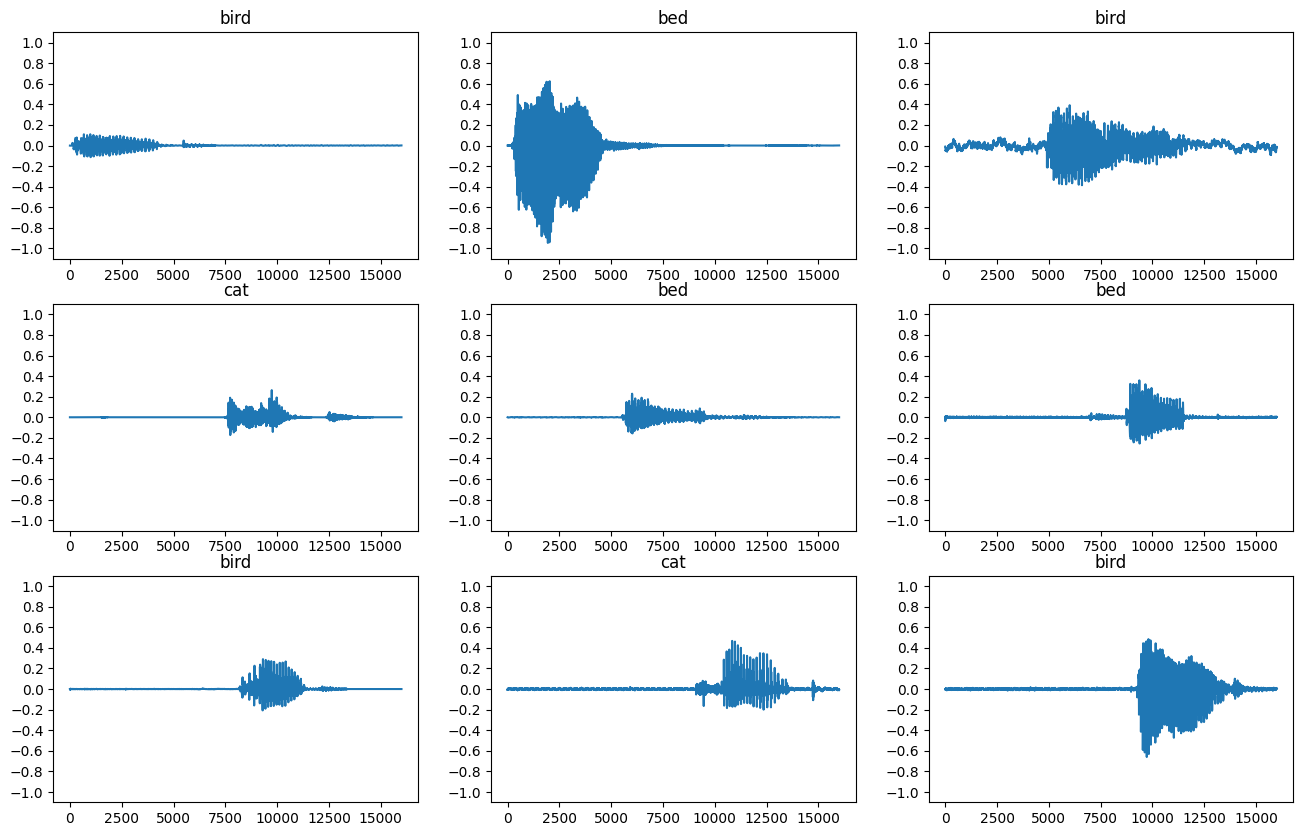

In [142]:
# 画出一个batch 的具体几个音频
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  # y 轴显示刻度值与范围
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: bed
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


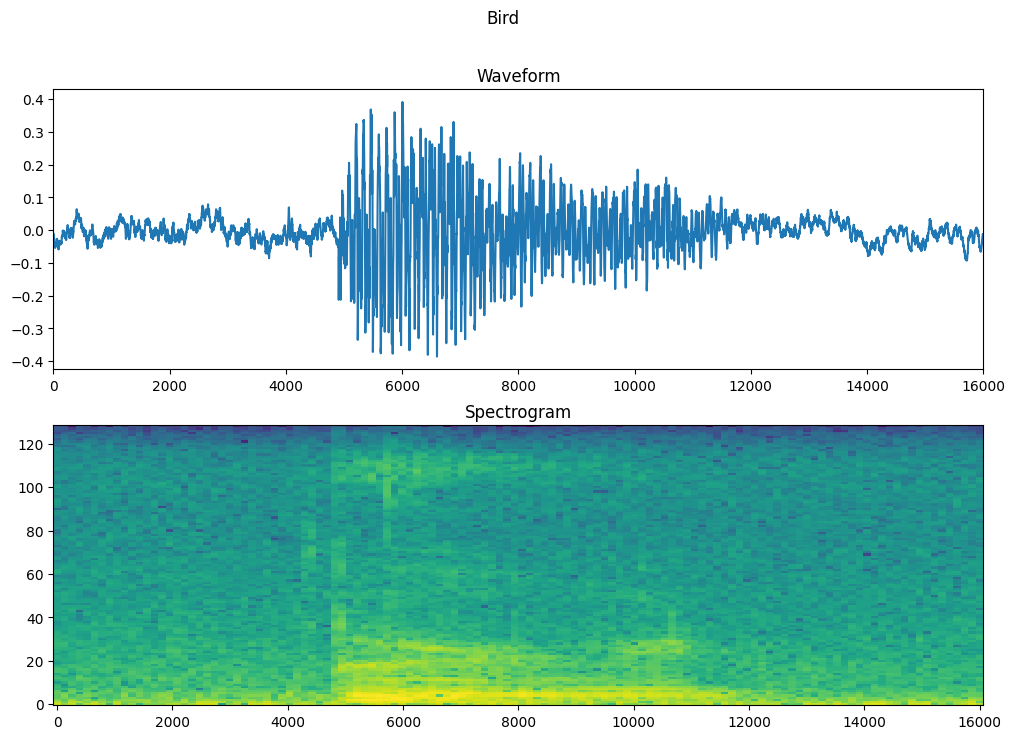

In [143]:
# 原始信号转化为频谱图试验
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

# 创建数据集

In [144]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

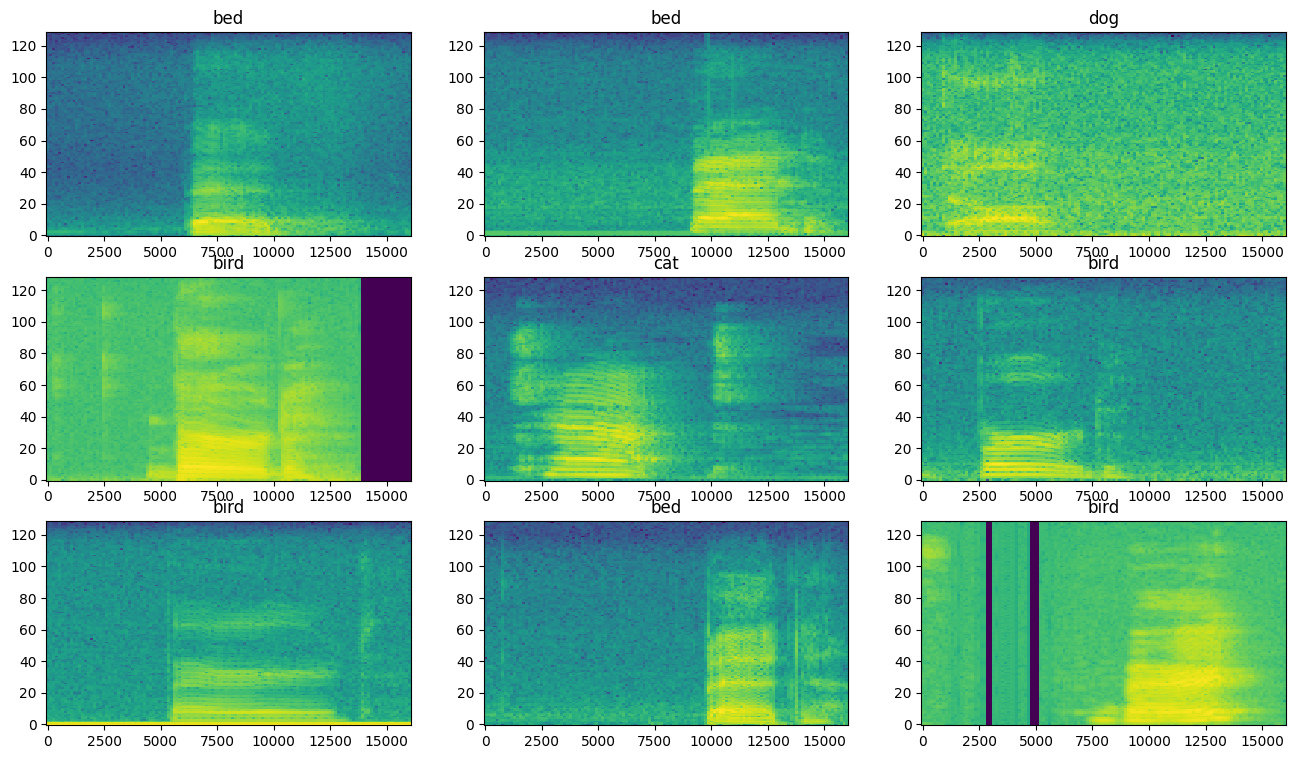

In [145]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# 构建并训练模型

In [146]:
# 添加buffer
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# 构建模型
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     # Downsample the input.
#     layers.Resizing(32, 32),
#     # Normalize.
#     norm_layer,
#     layers.Conv2D(32, 3, activation='relu'),
#     layers.Conv2D(64, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_labels),
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # Downsample the input.
    tf.keras.layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 10
# history = model.fit(
#     train_spectrogram_ds,
#     validation_data=val_spectrogram_ds,
#     epochs=EPOCHS,
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
# )
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)],
)

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)       

11/11 [==============================] - 0s 8ms/step


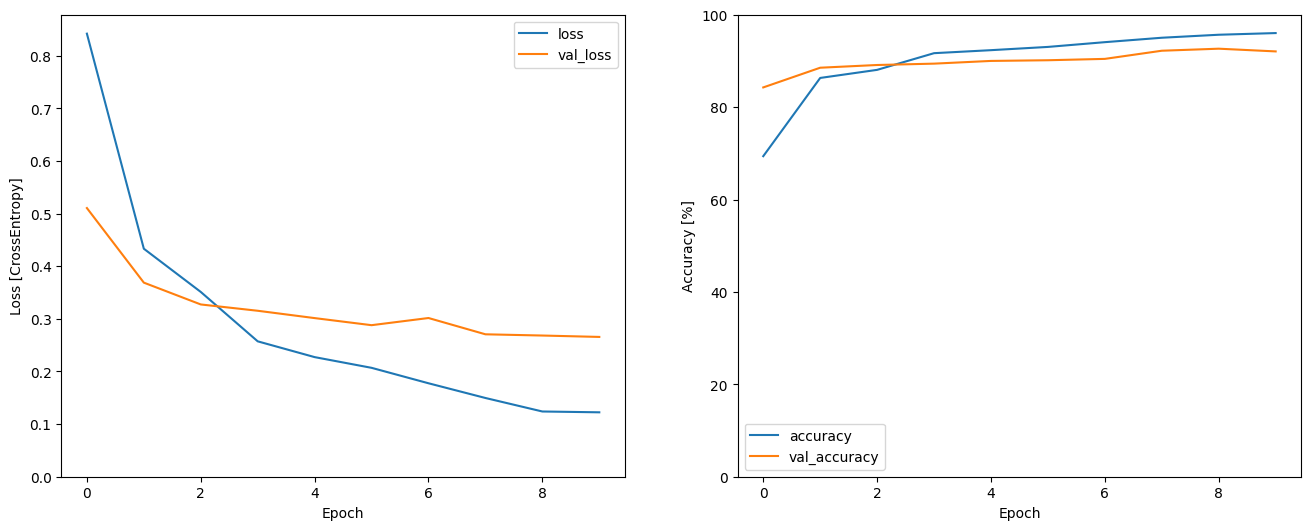

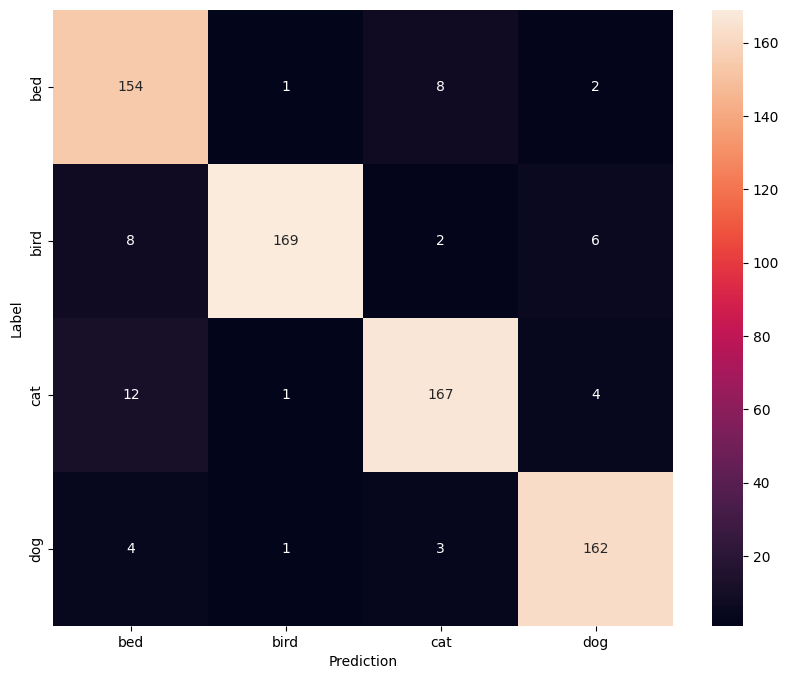

In [147]:
# 打印模型训练日志

metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# 测试集整体评估
model.evaluate(test_spectrogram_ds, return_dict=True)

y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# 单个文件预测

tf.Tensor(b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data\x00}\x00\x00\xff\xff\xea\xff\xe3\xff\xef\xff\xf6\xff\xf2\xff\xed\xff\xee\xff\xee\xff\xeb\xff\xf5\xff\x08\x00\x11\x00\xfa\xff\xec\xff\x11\x00B\x00(\x00\xd1\xff\xc9\xff-\x00s\x00\x19\x00\x8d\xff\xb7\xffk\x00\x9d\x00\xf1\xffe\xff\xc5\xffq\x00Z\x00\xa6\xffl\xff\xf2\xffy\x00L\x00\xb4\xff\x83\xff\xdf\xff:\x00\x16\x00\xbe\xff\xb2\xff\xfc\xffE\x00C\x00\x06\x00\xad\xff\x93\xff\xec\xffC\x00\x0b\x00\x91\xff\xa3\xff3\x00r\x00\xff\xff\x83\xff\xad\xff7\x00l\x00\x1b\x00\xcb\xff\xd4\xff\x0e\x00\x17\x00\xd5\xff\xa1\xff\xc3\xff\x15\x00A\x00=\x00$\x00\x12\x00\x08\x00\x01\x00\x03\x00\xf7\xff\xe7\xff\xfd\xff\'\x00=\x00%\x00\xf6\xff\xdb\xff\xe5\xff\x04\x00\x1c\x00\'\x001\x006\x00*\x00\xff\xff\xd4\xff\xc9\xff\xd7\xff\xec\xff\x04\x00)\x00?\x00-\x00\x0b\x00\xf8\xff\xf3\xff\xed\xff\xeb\xff\xfa\xff\x15\x00&\x00\x1a\x00\xfa\xff\xe1\xff\xdf\xff\xe8\xff\xf2\xff\xfc\xff\x0e\x00%\x00\'\x00\x0b\x00\xec\xff\

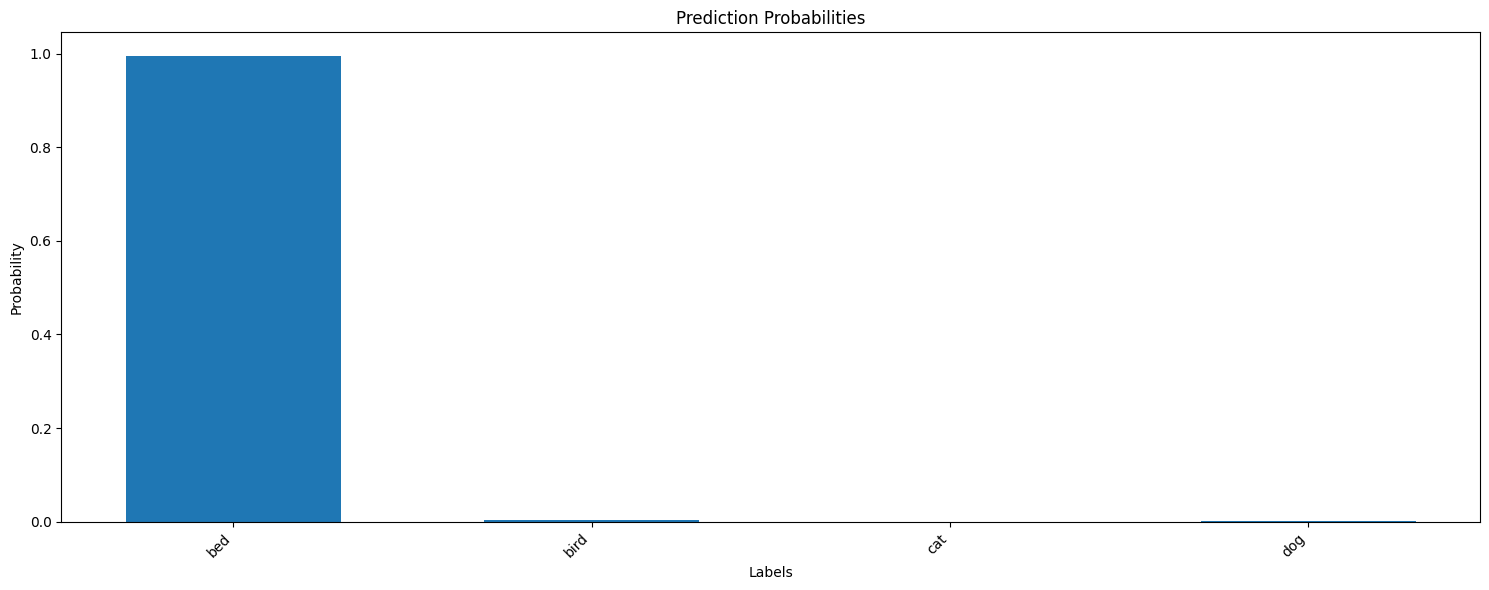

In [148]:
# 使用
x = './bed.wav'
x = tf.io.read_file(str(x))
print(x)
print(x.shape)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)

x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
prediction = model(x)
print(prediction)
x_labels = label_names
plt.figure(figsize=(15, 6))  # 增加图形的宽度
bar_width = 0.6  # 增加条形的宽度

plt.bar(x_labels, tf.nn.softmax(prediction[0]), width=bar_width)
plt.title('Prediction Probabilities')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.xticks(rotation=45, ha='right')  # 旋转标签以防止重叠
plt.tight_layout()  # 自动调整布局以确保所有元素可见
plt.show()

# 播放音频
display.display(display.Audio(waveform, rate=16000))


In [149]:
# 原始模型的输入为频谱图，需要对图像进行预处理才能输入模型
# 在此将调用图像的整个过程，预处理，调用，打印等封装到一个类中

class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}
  
Export = ExportModel(model)
result = Export(tf.constant(str('./bed.wav')))
print(result['class_names'].numpy()[0])

b'bed'


# 将模型写入文件

In [150]:
# 文件名
MODEL_NO_ABSTRACT = './MODEL_NO_ABSTRACT'
MODEL_TF = "./MODEL_TF"
MODEL_NO_QUANT_TFLITE = './MODEL_NO_QUANT_TFLITE'
MODEL_QUANT_TFLITE = './MODEL_QUANT_TFLITE'

# 未封装的原始模型
tf.saved_model.save(model, MODEL_NO_ABSTRACT)

# 原始模型
# 非 keras 的原生类不能调用 save API, 但可以调用tf.saved_model.save()
# model.save(MODEL_TF)
tf.saved_model.save(Export, MODEL_TF)

# 未量化 Lite 模型
# Converter 只能转化keras 的原生模型
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_NO_ABSTRACT)
model_no_quant_tflite = converter.convert()
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# 量化后 Lite 模型
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_NO_ABSTRACT)
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# 提供量化所需的代表数据集
# 获取代表数据集
train_spectrogram_ds = make_spec_ds(train_ds)
tensor_list = []
for i in range(10):
        tensor_temp = (list(train_spectrogram_ds)[i][0])
        tensor_list.append(tensor_temp)

concatenated_tensor = tf.concat(tensor_list, axis=0)
# 定义生成器函数
def representative_dataset():
        for i in range(500):
                sample = concatenated_tensor[i]
                sample = sample[tf.newaxis, ...]
                yield([sample])
converter.representative_dataset = representative_dataset
# 转化
model_quant_tflite = converter.convert()
# 写入
open(MODEL_QUANT_TFLITE, "wb").write(model_quant_tflite)

INFO:tensorflow:Assets written to: ./MODEL_NO_ABSTRACT\assets


INFO:tensorflow:Assets written to: ./MODEL_NO_ABSTRACT\assets


INFO:tensorflow:Assets written to: ./MODEL_TF\assets


INFO:tensorflow:Assets written to: ./MODEL_TF\assets


1632520

# 单个输入运行模型

In [151]:
# 调用TFLite 模型示例
def predict_tflite(tflite_model_path, x_path):
        # 获取输入信号(已经增加了批次维度)
        spectrogram_single = original_to_spectrogram(x_path)

        # 初始化解释器
        interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
        # 给模型分配内存
        interpreter.allocate_tensors()
        # 获取模型输入输出接口
        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]
        # 进行推断, ypred 为概率array
        interpreter.set_tensor(input_details["index"], spectrogram_single)
        interpreter.invoke()
        y_pred = interpreter.get_tensor(output_details["index"])[0]

        # 得到文本结果
        max_index = np.where(y_pred == np.max(y_pred))[0][0]
        category = label_names[max_index]
        
        return category

# 路径 --> 频谱图(shape + 1)
def original_to_spectrogram(x_path):
        spectrogram_single = tf.io.read_file(x_path)
        spectrogram_single, _ = tf.audio.decode_wav(spectrogram_single, desired_channels= 1, desired_samples=16000,)
        spectrogram_single = tf.squeeze(spectrogram_single, axis=-1)
        spectrogram_single = get_spectrogram(spectrogram_single)
        spectrogram_single = spectrogram_single[tf.newaxis, ...]

        return spectrogram_single

In [152]:
# 从文件导入模型并测试

# 未封装的原始模型
print("\nMODEL_NO_ABSTRACT:")
imported = tf.saved_model.load(MODEL_NO_ABSTRACT)
# 原始信号 --> 频谱图
spectrogram_single = original_to_spectrogram('./cat.wav')
# 预测
result = imported(spectrogram_single)
classId = tf.argmax(result, axis=1).numpy()[0]
className = tf.gather(label_names, classId).numpy()
print(className)

# 原始模型
print("\nMODEL_TF:")
imported = tf.saved_model.load(MODEL_TF)
result = imported(tf.constant(str("./dog.wav")))
print(result['class_names'].numpy()[0])

# 未量化 Lite 模型
print("\nMODEL_NO_QUANT_TFLITE:")
result = predict_tflite(MODEL_NO_QUANT_TFLITE, './bird.wav')
print(result)

# 量化后 Lite 模型
print("\nMODEL_QUANT_TFLITE:")
result = predict_tflite(MODEL_QUANT_TFLITE, './dog.wav')
print(result)



MODEL_NO_ABSTRACT:
b'cat'

MODEL_TF:
b'dog'

MODEL_NO_QUANT_TFLITE:
bird

MODEL_QUANT_TFLITE:
dog


# 模型比较

In [153]:
# 模型大小比较
def getFileSize(filePath, size=0):
    for root, dirs, files in os.walk(filePath):
        for f in files:
            size += os.path.getsize(os.path.join(root, f))
    return size

size_MODEL_NO_ABSTRACT= getFileSize(MODEL_NO_ABSTRACT)
size_MODEL_TF = getFileSize(MODEL_TF)
size_MODEL_NO_QUANT_TFLITE = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_MODEL_QUANT_TFLITE = os.path.getsize(MODEL_QUANT_TFLITE)

print(f"size_MODEL_NO_ABSTRACT: {size_MODEL_NO_ABSTRACT}")
print(f"size_MODEL_TF: {size_MODEL_TF}")
print(f"size_MODEL_NO_QUANT_TFLITE: {size_MODEL_NO_QUANT_TFLITE}")
print(f"size_MODEL_QUANT_TFLITE: {size_MODEL_QUANT_TFLITE}")

size_MODEL_NO_ABSTRACT: 19682731
size_MODEL_TF: 19722874
size_MODEL_NO_QUANT_TFLITE: 6503972
size_MODEL_QUANT_TFLITE: 1632520


In [154]:
# 预测效果比较
def evaluate_tflite(tflite_model_path, dataset):
        # 取出测试集
        array_list_spectrogram = []     
        array_list_label = []
        for data, label in dataset:
                array_list_spectrogram.append(data)
                array_list_label.append(label)
        combined_array_spectrogram = np.concatenate(array_list_spectrogram, axis=0)
        combined_array_label = np.concatenate(array_list_label, axis=0)  
        
        # 初始化解释器
        interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
        # 给模型分配内存
        interpreter.allocate_tensors()
        # 获取模型输入输出接口
        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]

        total_num = 0
        right_num = 0
        for spectrogram_single in combined_array_spectrogram:
                total_num = total_num + 1
                spectrogram_single = spectrogram_single[tf.newaxis, ...]

                # 进行推断, ypred 为概率array
                interpreter.set_tensor(input_details["index"], spectrogram_single)
                interpreter.invoke()
                y_pred = interpreter.get_tensor(output_details["index"])[0]
                # 获取最大概率索引
                category_index = np.where(y_pred == np.max(y_pred))[0][0]
                # 验证推断
                if category_index == combined_array_label[total_num - 1]:
                        right_num += 1
                
        return  right_num/total_num    

def evaluate_normal(tf_model_path, dataset):
        # 取出测试集
        array_list_spectrogram = []     
        array_list_label = []
        for data, label in dataset:
                array_list_spectrogram.append(data)
                array_list_label.append(label)
        combined_array_spectrogram = np.concatenate(array_list_spectrogram, axis=0)
        combined_array_label = np.concatenate(array_list_label, axis=0)

        total_num = 0
        right_num = 0
        # 进行推断
        model = tf.saved_model.load(tf_model_path)
        for spectrogram_single in combined_array_spectrogram:
                total_num += 1

                spectrogram_single = spectrogram_single[tf.newaxis, ...]  
                result_array = model(spectrogram_single).numpy()
                # 结果处理
                result_num = np.max(result_array, axis=1)
                result_index = np.where(result_array == result_num)[1][0]
                # 验证推断
                if result_index == combined_array_label[total_num - 1]:
                        right_num += 1               
                
        return right_num/total_num 



# 获取测试集
test_spectrogram_ds = make_spec_ds(test_ds)
print("acuracy:\n")

temp = evaluate_normal(MODEL_NO_ABSTRACT, test_spectrogram_ds)
print(f"MODEL_NO_ABSTRACT: {temp}")

temp = evaluate_tflite(MODEL_NO_QUANT_TFLITE, test_spectrogram_ds)
print(f"MODEL_NO_QUANT_TFLITE: {temp}")

temp = evaluate_tflite(MODEL_QUANT_TFLITE, test_spectrogram_ds)
print(f"MODEL_QUANT_TFLITE: {temp}")


acuracy:

MODEL_NO_ABSTRACT: 0.9261363636363636
MODEL_NO_QUANT_TFLITE: 0.9261363636363636
MODEL_QUANT_TFLITE: 0.8835227272727273
